## 影像圖片分類深度學習模型 - CNN圖片分類模型訓練與預測

<font color='SKYBLUE'>大綱:</font>
1. 載入數據
2. 訓練資料預處理
3. CNN 模型建模與訓練
4. 預測
5. 探索模型隱藏層

# 1. 載入數據

In [1]:
# 匯入模組
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default') # 設定主題配色

import keras
from keras.preprocessing.image import load_img # 載入img
from keras.preprocessing.image import img_to_array # img轉矩陣
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout

#Conv2D 卷積層, MaxPooling2D 池化層, Flatten 平坦層
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras import models

# 以下為 TensorFlow 1.x 用法
# from keras.utils import to_categorical  # # One-Hot Encoding
# from tensorflow.keras.utils import plot_model  # 繪製模型圖

# 以下為 TensorFlow 2.x 用法
from tensorflow.python.keras.utils.np_utils import to_categorical  # # One-Hot Encoding
from tensorflow.python.keras.utils.vis_utils import plot_model  # 繪製模型圖


In [2]:
# 定義參數
num_classes = 10  # 分類數量
img_rows, img_cols = 28, 28  # 圖像寬、高


In [3]:
# 載入 MNIST 訓練與測試資料
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


# 2. 訓練資料預處理
- CNN 輸入數據=4維
- MLP輸入數據=2維(60000,784)

In [4]:
# 依據Keras版本與資料格式不同，先查詢
K.image_data_format()


'channels_last'

In [5]:
# 三維轉四維，CNN輸入需使用四維矩陣
#channels_first Channels放在第2維度，第3、4維度放置 寬Width 與 高Height
#channels_last 第2、3維度放置寬與高，Channels放在第4維度
if K.image_data_format() == 'channels_first':
    x_train_new = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_new = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_new = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_new = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(x_train_new.shape)
print(x_test_new.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 2-1. X 訓練資料標準化

In [6]:
# 整數轉浮點數
x_train_norm = x_train_new.astype('float32')
x_test_norm = x_test_new.astype('float32')

# 直接除以最大值，標準化成0~1浮點數
x_train_norm /= 255
x_test_norm /= 255

print('x_train shape:', x_train_norm.shape)
print(x_train_norm.shape[0], 'train samples')
print(x_test_norm.shape[0], 'test samples')
# (總數據筆數60000, 寬28, 高28, 通道1) 灰階
# 影像完整被送進模型(28,28,1) MLP(784)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## 2-2. Y 訓練資料 one hot encoding

In [7]:
# 配合模型輸出10分類將標籤轉為one-hot
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

print(y_train[0] , y_train_onehot[0])


5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# 3. CNN 模型建模與訓練

## 3-1. 建立模型
權重`(Weights)`:每個神經元連結都賦予`權重值`，如果該`特徵`重要`權重值`會在`訓練中`逐漸提高

In [9]:
# 建模
model = Sequential(name='CNN-mnist')
model.add(Conv2D(24, kernel_size=(5, 5), activation='relu', input_shape=input_shape, name='Conv-1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Pooling-1'))
model.add(Conv2D(48, (5, 5), activation='relu', name='Conv-2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Pooling-2'))
model.add(Flatten())
# model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# 繪製模型圖
# plot_model(model, show_shapes=True, show_layer_names=False)


Model: "CNN-mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv-1 (Conv2D)             (None, 24, 24, 24)        624       
                                                                 
 Pooling-1 (MaxPooling2D)    (None, 12, 12, 24)        0         
                                                                 
 Conv-2 (Conv2D)             (None, 8, 8, 48)          28848     
                                                                 
 Pooling-2 (MaxPooling2D)    (None, 4, 4, 48)          0         
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               196864    
                                                                 
 dense_3 (Dense)             (None, 10)                25


## 3-2. 編譯及訓練擬合

In [10]:
# 編譯
%%time
# 另一種寫法
# model.compile(loss=keras.losses.categorical_crossentropy,
#       optimizer=keras.optimizers.Adadelta(),
#       metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


CPU times: user 22 ms, sys: 0 ns, total: 22 ms
Wall time: 28.7 ms


In [11]:
# 訓練擬合
epochs = 12  # 訓練週期
batch_size = 1000  # 批量訓練樣本數

history = model.fit(x_train_norm, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_norm, y_test_onehot))


Epoch 1/12
60/60 [==============================] - 6s 18ms/step - loss: 0.5989 - accuracy: 0.8442 - val_loss: 0.1660 - val_accuracy: 0.9506
Epoch 2/12
60/60 [==============================] - 1s 13ms/step - loss: 0.1348 - accuracy: 0.9602 - val_loss: 0.0950 - val_accuracy: 0.9715
Epoch 3/12
60/60 [==============================] - 1s 13ms/step - loss: 0.0870 - accuracy: 0.9739 - val_loss: 0.0602 - val_accuracy: 0.9811
Epoch 4/12
60/60 [==============================] - 1s 13ms/step - loss: 0.0650 - accuracy: 0.9803 - val_loss: 0.0514 - val_accuracy: 0.9845
Epoch 5/12
60/60 [==============================] - 1s 13ms/step - loss: 0.0530 - accuracy: 0.9841 - val_loss: 0.0450 - val_accuracy: 0.9862
Epoch 6/12
60/60 [==============================] - 1s 13ms/step - loss: 0.0452 - accuracy: 0.9864 - val_loss: 0.0390 - val_accuracy: 0.9871
Epoch 7/12
60/60 [==============================] - 1s 13ms/step - loss: 0.0394 - accuracy: 0.9880 - val_loss: 0.0359 - val_accuracy: 0.9880
Epoch 8/12
60

## 3-3. 評估模型

In [12]:
# 使用測試集
score = model.evaluate(x_test_norm, y_test_onehot, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


313/313 [==============================] - 3s 9ms/step - loss: 0.0293 - accuracy: 0.9901
Test loss: 0.02930833213031292
Test accuracy: 0.9901000261306763


In [13]:
# 使用自訂函數讀取 history 以圖表顯示訓練過程

def show_history(history, train, validation):
    fig = plt.gcf()
    fig.set_size_inches(8,3)
    plt.plot(history.history[train])  #訓練過程
    plt.plot(history.history[validation])  #驗證過程
    plt.title('Training History')  #標題
    plt.ylabel(train)   #縱軸是accuracy 與 loss 記錄
    plt.xlabel('Epoch')  #橫軸是訓練週期
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


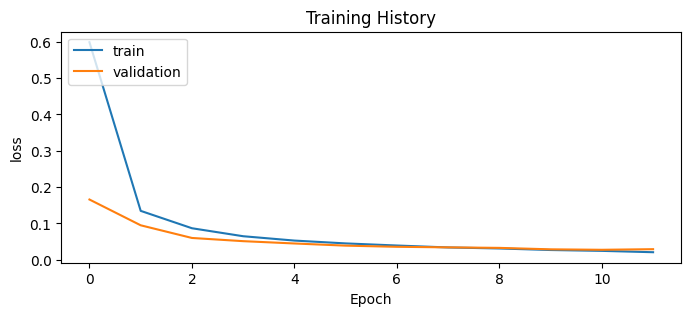

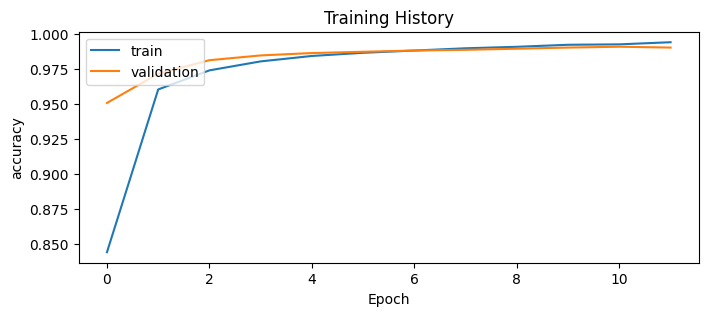

In [14]:
# 比較訓練 loss 與驗證 loss
show_history(history, 'loss', 'val_loss')
show_history(history, 'accuracy', 'val_accuracy')


# 4. 預測

In [15]:
# 預測分類 x_test_norm
# prediction = model.predict_classes(x_test_norm)

prediction_prob = model.predict(x_test_norm)
prediction = prediction_prob.argmax(axis = -1)

print(prediction_prob[240])
print(prediction[240:250]) # 顯示預測結果


313/313 [==============================] - 1s 2ms/step
[1.4281080e-12 3.7869798e-11 5.1522453e-10 1.2446511e-05 4.3782220e-13
 9.9997616e-01 4.9478039e-09 2.9903497e-13 2.3194441e-06 9.1714892e-06]
[5 9 8 7 2 3 0 2 4 2]


In [16]:
# 找出錯誤的
no = 0
print('錯誤分析列表:')
for i in range(len(prediction)):
  if prediction[i] != y_test[i]:
    # print('第 %d'筆標籤是: %d  ，錯誤預測成: %d' % (i, y_test[i], prediction[i]))
    no = no + 1
print(no)

print('正確數：', sum(prediction==y_test))
print('錯誤數：', sum(prediction!=y_test))
print('正確率：', (10000-no)/10000)


錯誤分析列表:
99
正確數： 9901
錯誤數： 99
正確率： 0.9901


# 用 Pandas 進行分析

## 顯示混淆矩陣 (Confusion matrix)

- 也稱為誤差矩陣
- 以表格化的方式顯示模型預測結果
- 查看模型預測結果，混淆了哪些類別 (將某一個標籤預測成另一個標籤)


In [17]:
# 顯示混淆矩陣 (Confusion matrix)
import pandas as pd

cm = pd.crosstab(index=y_test, columns=prediction, rownames=['label'], colnames=['predict'])
print(cm)

predict    0     1     2     3    4    5    6     7    8     9
label                                                         
0        976     0     0     0    0    0    1     2    1     0
1          0  1133     0     0    0    0    0     2    0     0
2          2     3  1017     0    0    0    0     8    2     0
3          0     0     1  1000    0    2    0     3    1     3
4          0     0     2     0  966    0    1     0    1    12
5          2     0     0     6    0  878    2     1    0     3
6          3     2     0     1    1    3  947     0    1     0
7          0     2     2     0    0    0    0  1023    1     0
8          4     0     1     0    0    2    0     2  961     4
9          0     1     0     1    1    1    0     4    1  1000


In [18]:
# 找出預測錯誤的影像
df = pd.DataFrame({'label':y_test, 'predict':prediction})
print(df[:5])  # 查看前五筆


   label  predict
0      7        7
1      2        2
2      1        1
3      0        0
4      4        4


In [19]:
## 找出對應的
df[(df.label==5)&(df.predict==3)]


,label,predict
340,5,3
1393,5,3
2035,5,3
2597,5,3
5937,5,3
5982,5,3


In [20]:
# 顯示預測結果
def show_predicted_probability(images, labels, prediction, probability, idx):
  plt.figure(figsize=(1,1));
  plt.xticks([]); plt.yticks([]); # 不要顯示刻度
  plt.imshow(images[idx], cmap='gray')
  plt.show()

  if len(labels)>0: print('label:', labels[idx])
  if len(labels)>0: print('predict:', prediction[idx])
  for i in range(10):
    print(i, ' Probability:%.9f'%(probability[idx][i]))


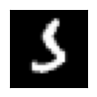

label: 5
predict: 3
0  Probability:0.000000572
1  Probability:0.000054505
2  Probability:0.000000523
3  Probability:0.812976837
4  Probability:0.000001307
5  Probability:0.186576396
6  Probability:0.000025355
7  Probability:0.000000000
8  Probability:0.000247848
9  Probability:0.000116787


In [21]:
show_predicted_probability(x_test, y_test, prediction, prediction_prob, 340)


# 5. 儲存模型

In [23]:
# 儲存Keras模型
print('Saving Model: my_mnist.h5 ...')
model.save('my_mnist.keras')


Saving Model: my_mnist.h5 ...


# 6. 探索 CNN 模型隱藏層 (bug 待處理)

1/1 [==============================] - 0s 199ms/step


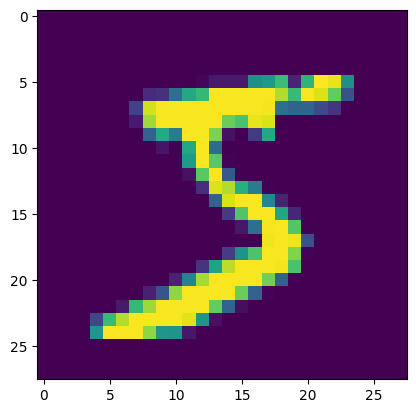

In [ ]:
# 顯示圖片
import matplotlib.pyplot as plt
test_im = x_train_norm[0]
plt.imshow(test_im. reshape(28,28), cmap='viridis', interpolation='none')

# 將test_im使用模型跑預測
layer_outputs = [layer.output for layer in model.layers[:-1]]
# act_model = keras.models.Model(input=model.input, output=layer_outputs)  # TensorFlow 1.x 用法
act_model = keras.models.Model(model.input, layer_outputs)
activations = act_model.predict(test_im.reshape(1,28,28,1))


### 顯示隱藏層函數，屬於進階內容，主要是幫助理解CNN

In [ ]:
# 顯示隱藏層函數
def plt_layer(name):
  layer_names = []
  for layer in model.layers[:-2]: #選取要顯示的隱藏層
    layer_names.append(layer.name)
  images_per_row = 16
  for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith(name): # conv max drop
      n_features = layer_activation.shape[-1]
      size = layer_activation.shape[1]
      n_cols = n_features // images_per_row
      display_grid = np.zeros((size * n_cols, images_per_row * size))
      for col in range(n_cols):
        for row in range(images_per_row):
          channel_image = layer_activation[0,:, :, col * images_per_row + row]
          channel_image -= channel_image.mean()
          channel_image /= channel_image.std()
          channel_image *= 64
          channel_image += 128
          channel_image = np.clip(channel_image, 0, 255).astype('uint8')
          display_grid[col * size : (col + 1) * size,
                          row * size : (row + 1) * size] = channel_image
        #print(name,channel_image.shape) #顯示數據在每個層的矩陣形狀shape
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
      plt.title(layer_name+str(channel_image.shape)) #顯示數據在每個層的矩陣形狀shape
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')
      #print(display_grid.shape)


### 顯示`數據`在`隱藏層`的處理情形

In [ ]:
# conv max drop
plt_layer('conv')
plt_layer('max')
plt_layer('drop')
#顯示數據(28,28)在每個層的矩陣形狀shape


## Homework:

In [ ]:
# Homework
# H1. 修改參數批量訓練樣本數 batch_size=128 256 512 或是其他數值
# model準確率與訓練時間有何不同? del model

# H2. 更換手寫數字圖片,執行程式 觀察特徵擷取的過程


1/1 [==============================] - 0s 104ms/step


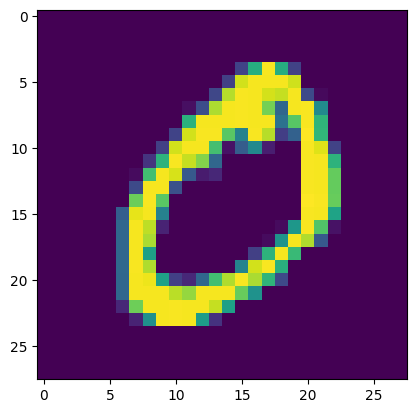

In [ ]:
# 顯示圖片
import matplotlib.pyplot as plt
test_im = x_train_norm[1]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')
#將test_im使用模型跑預測
act_model = keras.models.Model(model.input, layer_outputs)
activations = act_model.predict(test_im.reshape(1,28,28,1))


In [ ]:
# conv max drop
plt_layer('conv')
plt_layer('max')
plt_layer('drop')
# 顯示數據(28,28)在每個層的矩陣形狀shape


# 總結

### MLP第一個隱藏層是全連接層，輸入2D(二維)矩陣，影像是1D(一維)矩陣

In [ ]:
#
28*28 #(60000, 784)

784

### CNN第一個隱藏層是卷積層，輸入是4D(四維)矩陣，影像是(3D)三維矩陣

In [ ]:
#
x_train.shape

(60000, 28, 28)

### 兩者有何差異?
### 影像`像素`(特徵)彼此之間相對位置

卷積層`(Conv2D)`: 運算擷取特徵，使用`濾波器`凸顯重要特徵，減少`參數`與`運算量`

池化層`(MaxPooling2D)`:輸入的圖像劃分為若干個矩形區域，對每個子區域輸出最大值。

原理是一個`特徵的精確位置`遠不及與`其他特徵的相對位置`重要。

池化層會不斷地減小`數據的像素`，因此`參數的數量`和`運算量`也會下降，在`大尺寸圖片`尤其明顯。
